Импорт библиотек

In [2]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.7 MB/s eta 0:00:00


In [3]:

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Загрузка тестовых данных которые мы сделали в практиках ранее

In [5]:
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9710 - loss: 0.0898
Test accuracy on clean images: 0.9765999913215637


In [7]:
# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))
# Выбор изображения для атаки (например, первое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор
# Выполнение атаки
attack = fb.attacks.L2CarliniWagnerAttack(steps=3)
print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)  # Оборачиваем метку

tf.Tensor(7, shape=(), dtype=int64)


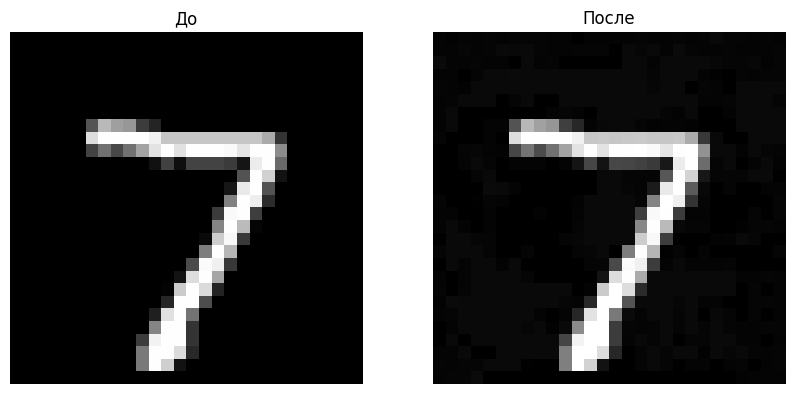

In [8]:
# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("До")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("После")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')
plt.show()

In [9]:
adversarial_images = []
# Обработка изображений
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]  # Форма (1, height, width, channels)
    label = np.argmax(test_labels[i])  # Получаем индекс класса
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)
adversarial_images = tf.concat(adversarial_images, axis=0)  # Объединение по нулевой оси
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Точность на состязательных примерах (атака CW): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0796 - loss: 2.2480
Точность на состязательных примерах (атака CW): 0.07930000126361847
